In [1]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from timeit import default_timer as timer
import xgboost as xgb

bin_count = 171

In [2]:
def find_first_zero(row):
    vals = list(row) 
  
    last_zero_index = -1
    for idx, val in enumerate(reversed(vals)): 
        if val > 0:
            last_zero_index = bin_count - idx
            break
    return last_zero_index

def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins. Add a c """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)
    #data_set['Output_Is_Not_End'] = ~data_set['Output_Is_End']
    
    

    data_set['Output_First_Zero'] = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]].apply(find_first_zero, axis=1)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End', 'Output_First_Zero'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End', 'Output_First_Zero']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

#filename = "/scratch/keh4nb/dust_training_data_all_bins_large.csv"
filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_163,Output_Bin_164,Output_Bin_165,Output_Bin_166,Output_Bin_167,Output_Bin_168,Output_Bin_169,Output_Bin_170,Output_Is_End,Output_First_Zero
count,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,...,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000
mean,4.788404e-03,3.511234e-03,3.102781e-03,3.476701e-03,3.457728e-03,3.501525e-03,3.642096e-03,3.778553e-03,3.935451e-03,4.021584e-03,...,0.001058,0.000883,0.000728,0.000676,0.001939,0.005278,0.016270,0.151275,0.167596,114.466395
std,1.166852e-02,7.803030e-03,6.573299e-03,7.853398e-03,6.781768e-03,6.542634e-03,6.904298e-03,6.660142e-03,7.485042e-03,6.836560e-03,...,0.006218,0.005424,0.004790,0.004623,0.006232,0.013469,0.040799,0.326542,0.373509,41.073065
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,1.413419e-11,5.957408e-11,2.004835e-10,7.735218e-10,2.203720e-09,4.972974e-09,1.233129e-08,2.641020e-08,5.567167e-08,1.080826e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.000000
50%,1.091139e-04,1.224256e-04,1.354748e-04,1.791490e-04,2.160863e-04,2.491617e-04,2.911052e-04,3.537974e-04,4.251557e-04,5.010170e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000
75%,2.666961e-03,2.534129e-03,2.509944e-03,2.984808e-03,3.315966e-03,3.667415e-03,4.060019e-03,4.502340e-03,4.900773e-03,5.306905e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000
max,9.354140e-02,5.693502e-02,4.501455e-02,3.978454e-01,1.493864e-01,3.745879e-02,2.716096e-01,3.748155e-02,3.097229e-01,1.159227e-01,...,0.087176,0.087361,0.087655,0.091350,0.105380,0.133252,0.245536,0.999991,1.000000,171.000000


Try xgboost for predicting whether all the particles are at the end of the distribution. Ended up getting over 99% test accuracy.

In [3]:
#%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_Is_End'],
             eval_set=[(X_train, y_train['Output_Is_End']), (X_test, y_test['Output_Is_End'])],
             eval_metric='error',verbose=False)

evals_result = xgb_model.evals_result()

In [4]:
preds = xgb_model.predict(X_test)

# Count the number of matches between predictions and labels
correct = np.sum(preds == y_test['Output_Is_End'])

# Calculate accuracy
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")

xgb_model.save_model('xgb_model_is_end.model')

Accuracy: 0.9992693037307665


Train a linear regression model for predicting when first zero occurs on models where the dust is not all stacked at the end.

In [6]:

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             eta=0.1,
                             n_estimators=150,
                             sub_sample=0.8,
                             colsample_bytree=0.8,
                             max_depth=8,
                              random_state=42)


# Only train on output not at end
output_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
X_first_zero = X_train.loc[output_not_end_idx]
y_first_zero = y_train.loc[output_not_end_idx, 'Output_First_Zero']

xgb_model.fit(X_first_zero, y_first_zero,
             eval_set=[(X_first_zero, y_first_zero)],
             eval_metric='rmse', early_stopping_rounds=10, verbose=True)

evals_result = xgb_model.evals_result()

[15:27:12] WARNING: ../src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:97.76301
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:88.06724
[2]	validation_0-rmse:79.34326
[3]	validation_0-rmse:71.51369
[4]	validation_0-rmse:64.46164
[5]	validation_0-rmse:58.09223
[6]	validation_0-rmse:52.37012
[7]	validation_0-rmse:47.21246
[8]	validation_0-rmse:42.57005
[9]	validation_0-rmse:38.39872
[10]	validation_0-rmse:34.64174
[11]	validation_0-rmse:31.26529
[12]	validation_0-rmse:28.22983
[13]	validation_0-rmse:25.50062
[14]	validation_0-rmse:23.04997
[15]	validation_0-rmse:20.85611
[16]	validation_0-rmse:18.87436
[17]	validation_0-rmse:17.09471
[18]	validation_0-rmse:15.50637
[19]	va

Best train result is 1.116 RMSE. Best test RMSE is 1.3

In [7]:
from sklearn.metrics import mean_squared_error as MSE 

#Optionally load pretrained model
# Load first zero model
#xgb_model = xgb.XGBRegressor()
#xgb_model.load_model('xgb_model_first_zero.model')

# Only predict on output not at end
output_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]
X_test_first_zero = X_test.loc[output_not_end_test_idx]
y_test_first_zero = y_test.loc[output_not_end_test_idx, 'Output_First_Zero']

# Predict the model. Round preds since bins are whole numbers
pred = np.rint(xgb_model.predict(X_test_first_zero)) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test_first_zero, pred)) 
print(f"RMSE : {rmse}") 

pd.set_option('display.max_rows', None)
print(pd.DataFrame({"preds":pred, "test":y_test_first_zero}).head(25))

RMSE : 1.939649134678017
         preds  test
812479   112.0   112
282690    90.0    90
12849    171.0   171
1084258   97.0    97
409314   168.0   168
1185958   64.0    64
624375   133.0   134
699524    64.0    64
616329    91.0    92
566969   108.0   110
998258    49.0    49
827418    94.0    93
639061    66.0    67
808437   113.0   113
266382   148.0   148
1005452  101.0   102
107326   132.0   132
129889   160.0   160
760585    84.0    83
598600   155.0   155
307323   145.0   145
1346253   55.0    54
216224   122.0   122
298282   116.0   116
675132    65.0    65


In [8]:
xgb_model.save_model('xgb_model_first_zero.model')

Train two MDNs, one on the dust at end and one without

In [9]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(512, activation=activation, name='baselayer')(input)
    layer_2 = tf.keras.layers.Dense(128, activation=activation, name='layer_2')(layer)
    layer_3 = tf.keras.layers.Dense(64, activation=activation, name='layer_3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(32, activation=activation, name='layer_4')(layer_3)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_3)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam()
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=opt)
    model.summary()
    return model

Build a mdn model for the outputs where the dust is at the end of the distribution

In [10]:

#model_spike = build_mdn_model(k=64)
model_spike = build_mdn_model(k=32)
output_is_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X = X_train.loc[output_is_end_idx]
y = y_train.loc[output_is_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
print(y.shape)
spike_fit = model_spike.fit(x=X, y=y, batch_size=512, epochs=50, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 179)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 512)               92160     
_________________________________________________________________
layer_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
mdn (MDN)                    (None, 10976)             713440    
Total params: 879,520
Trainable params: 879,520
Non-trainable params: 0
_________________________________________________________________
(214335, 171)
Epoch 1/50
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
37

In [11]:
model_spike.save("spiked_mdn_model/model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: spiked_mdn_model/model/assets


In [12]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):

    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    # Convert negatives to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

Make predictions for this model and evaluate the results

In [13]:
output_is_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_spike = X_test.loc[output_is_end_idx]
y_test_spike = y_test.loc[output_is_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

model_spike = tf.keras.models.load_model('spiked_mdn_model/model', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, 32)})


spike_preds = predict_for_test(model_spike, X_test_spike, y_test_spike, 32)
#spike_preds = model_spike.predict(X_test)

Total time taken: 5377.051542811096. Seconds per prediction: 0.22541508941104618


In [17]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
# Renormalize samples
preds_normalized = []
for s in preds:
    preds_normalized.append(np.divide(s,np.sum(s)))

def evaluate_fit(y_samples, y_test):
    ent = []
    js_list = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)

    #y_test_obs = [obs_from_bins(s.array) for idx, s in y_test.iterrows()]
    #y_samples_obs = [obs_from_bins(s) for s in y_samples]
    
    y_samples_obs = y_samples
    y_test_obs = y_test
    
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_test_obs += c
    y_samples_obs += c

    #print(y_test_obs)
    for i in range(len(y_test_obs)):
        e = entropy(y_test_obs.iloc[i], y_samples_obs[i])
        js = jensenshannon(y_test_obs.iloc[i], y_samples_obs[i])
        ent.append(e if e != np.inf else 1000)
        js_list.append(js)
    display(pd.DataFrame(ent).describe())
    display(pd.DataFrame(js_list).describe())

/usr/local/lib/python3.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


Before changing the entropy calculation, mean 7.8, min 0.03, median 2.9, max, 116.3.
Instead of entropy, what about jensenshannon?

In [18]:
evaluate_fit(y_samples_spike_normalized, y_test_spike)

,0
count,23854.000000
mean,0.506773
std,1.658731
min,0.046695
25%,0.066616
50%,0.081529
75%,0.181691
max,27.840138


,0
count,23854.000000
mean,0.178112
std,0.047426
min,0.125864
25%,0.147680
50%,0.157149
75%,0.191048
max,0.631574


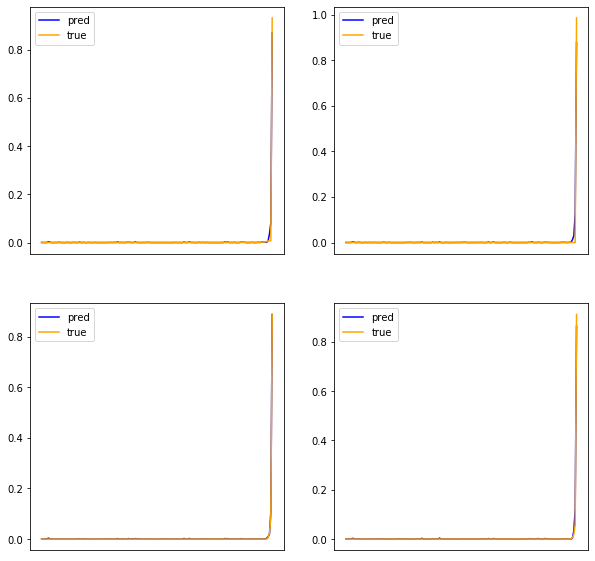

In [19]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = spike_preds[i]
    true = y_test_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Create a seperate mdn model to use on the rest.

Identify what type of distribution the non-spiked data is from y-train

In [16]:
model_non_spike = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1)
non_spike_fit = model_non_spike.fit(x=X, y=y, batch_size=1024, epochs=50, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 179)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 512)               92160     
_________________________________________________________________
layer_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
mdn (MDN)                    (None, 5488)              356720    
Total params: 522,800
Trainable params: 522,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
938/938 [==============================] - 60s 64ms/step - loss: -512.9330 - val_loss: -537.2432
Epoch 

In [21]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non_spike = X_test.loc[output_is_not_end_idx]
y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

non_spike_preds = predict_for_test(model_non_spike, X_test_non_spike, y_test_non_spike, 16)

Total time taken: 3960.145193617791. Seconds per prediction: 0.03342571654696133


Mean was 25 before changes

In [22]:
evaluate_fit(non_spike_preds, y_test_non_spike)

,0
count,118476.000000
mean,18.418227
std,23.985525
min,0.213638
25%,3.186895
50%,9.792068
75%,22.816309
max,210.919615


,0
count,118476.000000
mean,0.539868
std,0.094348
min,0.192620
25%,0.473531
50%,0.535540
75%,0.603538
max,0.824166


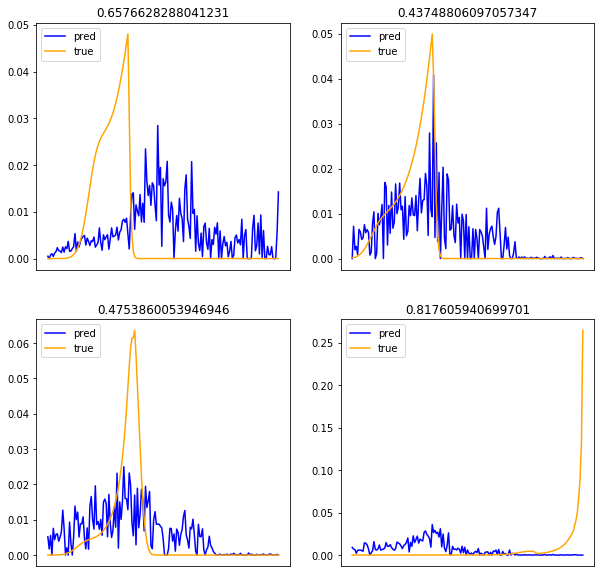

In [26]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = non_spike_preds[i]
    true = y_test_non_spike.iloc[i]
    
    c = 1e-100
    
    test_pred += c
    true += c
    
    
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    js = jensenshannon(true, test_pred)
    #e = entropy(true, test_pred)
    ax.set_title(js)
    
plt.show()

Try to find the best tuning parameters for the neural network. The network gets stuck predicting everything as 0 (75% accuracy), but cannot improve on it.

In [ ]:
#%pip install -U keras-tuner
import kerastuner as kt

def build_model(hp):
        # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    activation = 'selu'

    # Network
    input = tf.keras.Input(shape=(l,))

    layer =  tf.keras.layers.Dense(hp.Int('hidden_size', 16, 256, step=16, default=128), activation=hp.Choice('activation', values=['relu', 'selu', 'tanh', 'swish'], default='relu'), name='baselayer')(input)
    #layer = tf.keras.layers.Dense(1024, activation='relu', name='baselayer')(input)
    #layer_2 = tf.keras.layers.Dense(1024, activation='tanh', name='baselayer2')(layer)
    #layer_3 = tf.keras.layers.Dense(16, activation='tanh', name='baselayer3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(64, activation=activation, name='baselayer4')(layer_3)
    #layer_5 = tf.keras.layers.Dense(32, activation=activation, name='baselayer5')(layer_4)
    # Connect the mdn layer to the output of our neural network
    #mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_5)
    #model = tf.keras.models.Model(input, [mdn_layer])

    # 2 classes
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(layer)
    model = tf.keras.models.Model(input, [outputs])


    #opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))
    #model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.tuners.BayesianOptimization(
  build_model,
  objective='val_accuracy',
  max_trials=50)

tuner.search(x=X_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1, class_weight=cweights, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [5]:
preds = model.predict(X_test)
display(pd.DataFrame(preds).describe())
display(y_test.describe())

,0
count,40017.000000
mean,0.502865
std,0.064357
min,0.042015
25%,0.452332
50%,0.509930
75%,0.547307
max,0.598693


,Output_Is_End
count,40017.000000
mean,0.243771
std,0.429362
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [93]:
tuner.results_summary()

In [95]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2394/2394 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.78 - ETA: 1s - loss: 0.6925 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accura

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1251/1251 [==============================] - 1s 513us/step - loss: 0.6914 - accuracy: 0.5298
Test accuracy: 0.5297748446464539
